In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

folders = os.listdir('/content/drive/MyDrive/물공모전')

In [ ]:
cd /content/drive/MyDrive/물공모전

/content/drive/MyDrive/물공모전


In [ ]:
data = pd.read_csv('data_jh_final.csv')

In [ ]:
data.columns = ['수질등록일자','방류수BOD','방류수TN']

In [ ]:
dataB = data[['수질등록일자','방류수BOD']]
dataT = data[['수질등록일자','방류수TN']]
dataB.head()

,수질등록일자,방류수BOD
0,2019-01-01,14.4
1,2019-01-02,14.0
2,2019-01-03,12.2
3,2019-01-04,12.6
4,2019-01-05,15.0


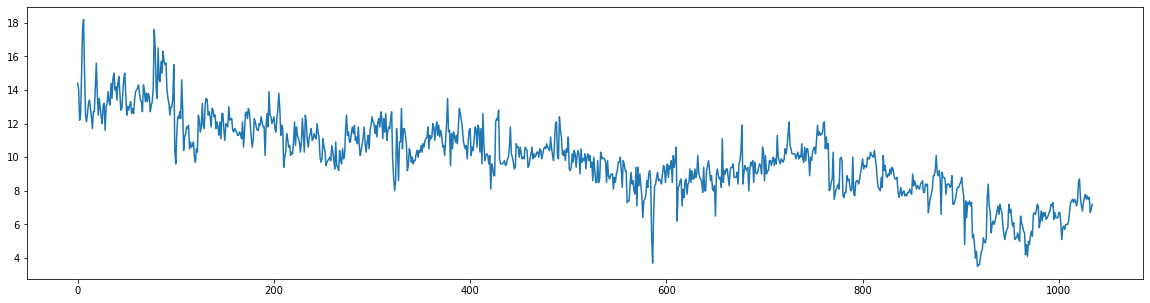

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(len(dataB)), dataB["방류수BOD"])

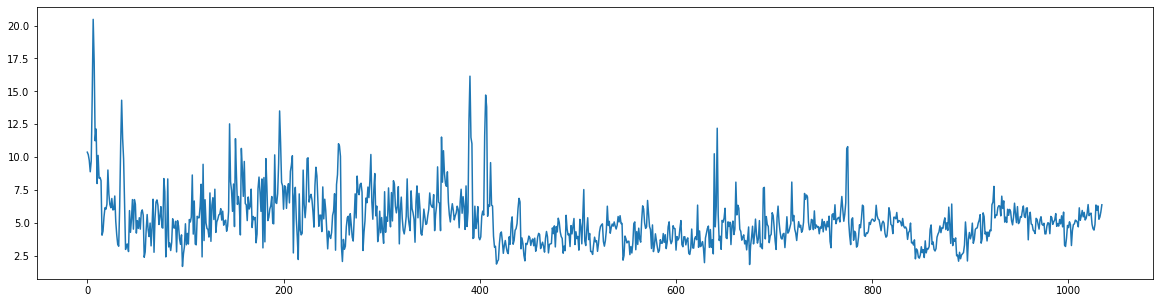

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(len(dataT)), dataT["방류수TN"])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

dataB["방류수BOD"] = min_max_scaler.fit_transform(dataB["방류수BOD"].to_numpy().reshape(-1,1))
data_trainB = dataB[:-24*7]
trainB = data_trainB["방류수BOD"].to_numpy()
data_testB = dataB[-24*7:]
testB = data_testB["방류수BOD"].to_numpy()

dataT["방류수TN"] = min_max_scaler.fit_transform(dataT["방류수TN"].to_numpy().reshape(-1,1))
data_trainT = dataT[:-24*7]
trainT = data_trainT["방류수TN"].to_numpy()
data_testT = dataT[-24*7:]
testT = data_testT["방류수TN"].to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# Transformer - Encoder, Decoder

### Sliding WIndow Dataset
시계열 예측을 위해 데이터의 일정한 길이의 input window, output window를 설정하고, 데이터의 처음 부분부터 끝부분까지 sliding 시켜서 데이터셋을 생성.<br>
input window를 모델의 인풋으로, output window를 모델의 아웃풋으로 사용.

In [ ]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

input window, output window, stride를 입력받고 iw+ow만큼의 길이를 stride간격으로 sliding하면서 데이터세 생성.<br>
transformer의 input, decoder intput, output으로 활용하기 위해 세 가지의 값을 return하도록 만들었다. <br>
첫 번째 값으로는 input window, 두 번째 값으로는 output window에서 마지막 값을 제외한 값, 마지막 값으로는 output window에서 첫 번째 값을 제외한 값을 return하도록 했다.

In [ ]:
iw = 24*14
ow = 24*7

train_datasetB = windowDataset(trainB, input_window=iw, output_window=ow, stride=1)
train_loaderB = DataLoader(train_datasetB, batch_size=64)

train_datasetT = windowDataset(trainT, input_window=iw, output_window=ow, stride=1)
train_loaderT = DataLoader(train_datasetT, batch_size=64)

output window의 크기로는 예측을 하려는 길이인 24*7로 설정했고, input window의 크기는 그 두배로 설정

### Modeling

In [ ]:
from torch.nn import Transformer
from torch import nn
import torch
import math

In [ ]:
class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1)
        self.encoder = nn.Linear(1, d_model)
        self.encoder_d = nn.Linear(1, d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src)
        src = self.pos_encoder(src)

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

데이터가 univariate time series이므로 input과 output의 차원은 모두 1차원이다.<br>
인풋 데이터인 1차원의 벡터를 d_model의 차원으로 linear layer를 통해 바꿔준 후 positional encoding을 거쳐서 transformer를 통과하게 만들었다. 결과의 차원을 다시 1차원으로 만들어서 최종 output이 나오도록 했다.<br>
패딩없이 모든 데이터가 값을 가지고 있으므로 padding mask는 생략.

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 1e-3
model = TFModel(256, 8, 256, 2, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epoch = 100 #원래는 2000? 5는 너무 적다 ...
from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loaderB:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loaderB)))

0.00863: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 1e-3
model2 = TFModel(256, 8, 256, 2, 0.1).to(device)
criterion2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)

In [ ]:
epoch = 100
from tqdm import tqdm

model2.train()
progress2 = tqdm(range(epoch))
for i in progress2:
    batchloss2 = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loaderT:
        optimizer2.zero_grad()
        src_mask2 = model2.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask2 = model2.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result2 = model2(inputs.float().to(device), dec_inputs.float().to(device), src_mask2, tgt_mask2)
        loss2 = criterion(result2.permute(1,0,2), outputs.float().to(device))
        
        loss2.backward()
        optimizer2.step()
        batchloss2 += loss2
    progress2.set_description("{:0.5f}".format(batchloss2.cpu().item() / len(train_loaderT)))

0.00821: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


### Evaluate
학습된 모델을 이용해서 실제로 마지막 일주일의 데이터를 예측

In [ ]:
def evaluate(length, data_train, model):
    input = torch.tensor(data_train[-24*7*2:]).reshape(1,-1,1).to(device).float().to(device)
    output = torch.tensor(data_train[-1].reshape(1,-1,1)).float().to(device)
    model.eval()
    for i in range(length):
        src_mask = model.generate_square_subsequent_mask(input.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(output.shape[1]).to(device)

        predictions = model(input, output, src_mask, tgt_mask).transpose(0,1)
        predictions = predictions[:, -1:, :]
        output = torch.cat([output, predictions.to(device)], axis=1)
    return torch.squeeze(output, axis=0).detach().cpu().numpy()[1:]

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

인풋 데이터로 train data의 마지막 2주일의 데이터를 사용하고, 디코더의 인풋으로는 train data의 마지막 값을 사용했다.<br>
다음 값을 예측하는 과정을 예측할 길이만큼 반복하면서 output을 update했다.<br>
원하는 길이 만큼 예측을 완료하면 최종값을 return한다.

In [ ]:
resultB = evaluate(24*7*2, trainB, model)
resultB = min_max_scaler.inverse_transform(resultB)
realB = dataB["방류수BOD"].to_numpy()
realB = min_max_scaler.inverse_transform(realB.reshape(-1,1))

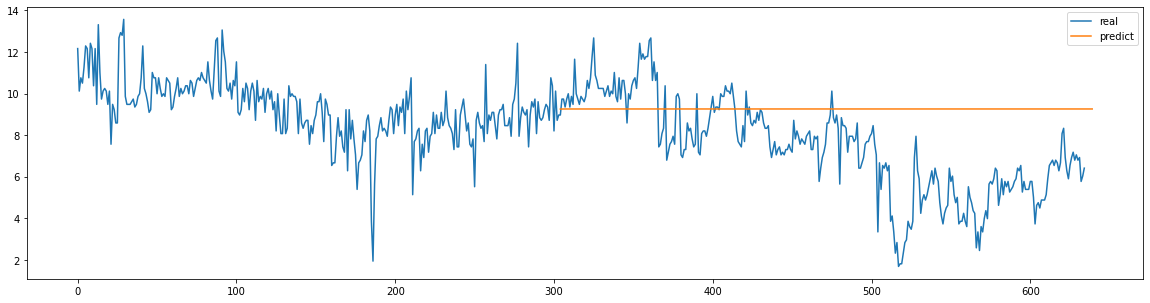

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(realB[400:], label="real")
plt.plot(range(640-24*7*2,640),resultB, label="predict")
#plt.plot(range(400,744),realB[400:], label="real")
#plt.plot(range(744-24*7,744),resultB, label="predict")
plt.legend()
plt.show()

In [ ]:
resultT = evaluate(24*7*2, trainT, model2)
resultT = min_max_scaler.inverse_transform(resultT)
realT = dataT["방류수TN"].to_numpy()
realT = min_max_scaler.inverse_transform(realT.reshape(-1,1))

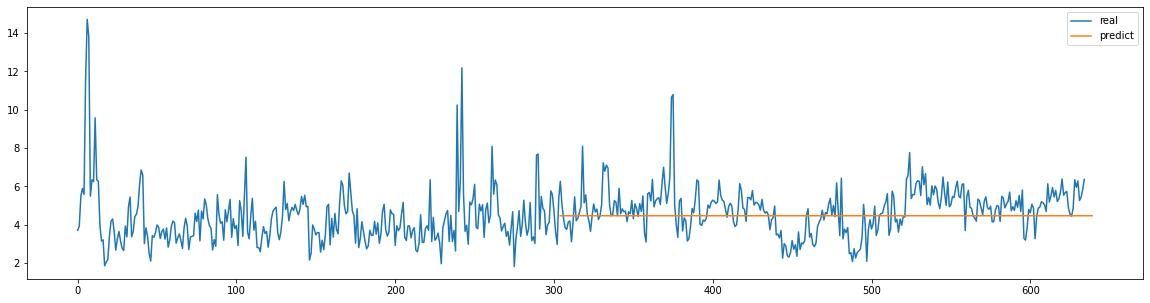

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(realT[400:], label="real")
plt.plot(range(640-24*7*2,640),resultT, label="predict")
#plt.plot(range(400,744),realB[400:], label="real")
#plt.plot(range(744-24*7,744),resultB, label="predict")
plt.legend()
plt.show()

In [ ]:
def MSEval(y_pred, y_true):
  #return 0.5*np.sum((y_pred-y_true)**2)
  return np.mean(np.abs(y_true - y_pred)**2)

print(MSEval(resultB, realB[-24*7*2:]))
print(MSEval(resultT, realT[-24*7*2:]))

8.485873622142176
1.39935319842045
